In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 40000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-24_17-50_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df = df.loc['20190101':'20190630']

In [5]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [6]:
allocs

ES       0.5
NQ       0.5
total    1.0
dtype: float64

In [7]:
df.groupby('contract').realizedPNL.sum()

contract
ES    3656.0
NQ    3710.4
Name: realizedPNL, dtype: float64

In [8]:
df.realizedPNL.sum()

7366.4000000000015

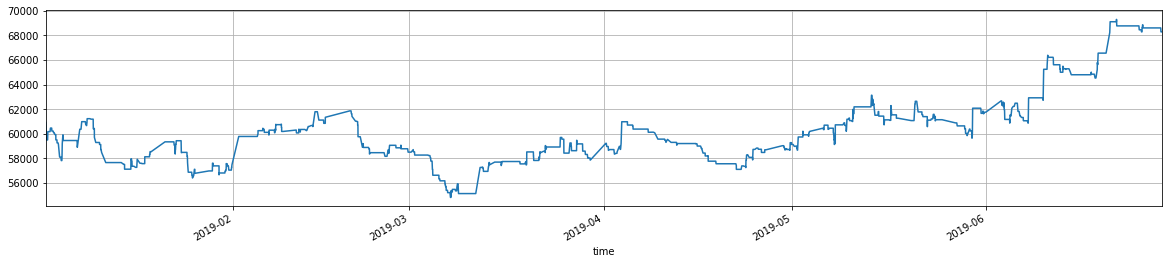

In [9]:
df.cash.plot(figsize=(20,4), grid=True);

In [10]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [11]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    140
 NQ    727
 Name: action, dtype: int64, 867)

In [12]:
# trades per day
days = len(by_contract.resample('D').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.786517
 NQ    4.084270
 Name: action, dtype: float64, 4.870786516853933)

In [13]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     294.0
NQ    1526.7
Name: commission, dtype: float64

In [14]:
df.commission.sum()

1820.7000000000005

In [15]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.38,10.22,369.01,-207.28,1.78,11.71,363.0
ES,0.50,52.23,670.09,-565.63,1.18,52.23,70.0
total,0.40,17.01,430.28,-255.33,1.69,18.91,433.0


In [16]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [17]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,NQ,total
contract,,,
ES,1.000000,0.082783,0.738748
NQ,0.082783,1.000000,0.732646
total,0.738748,0.732646,1.000000


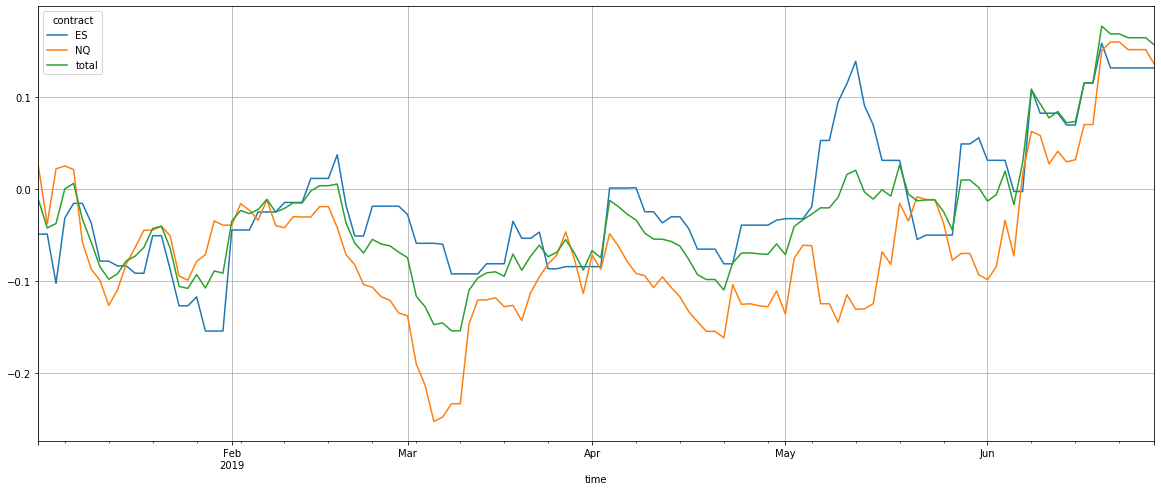

In [18]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

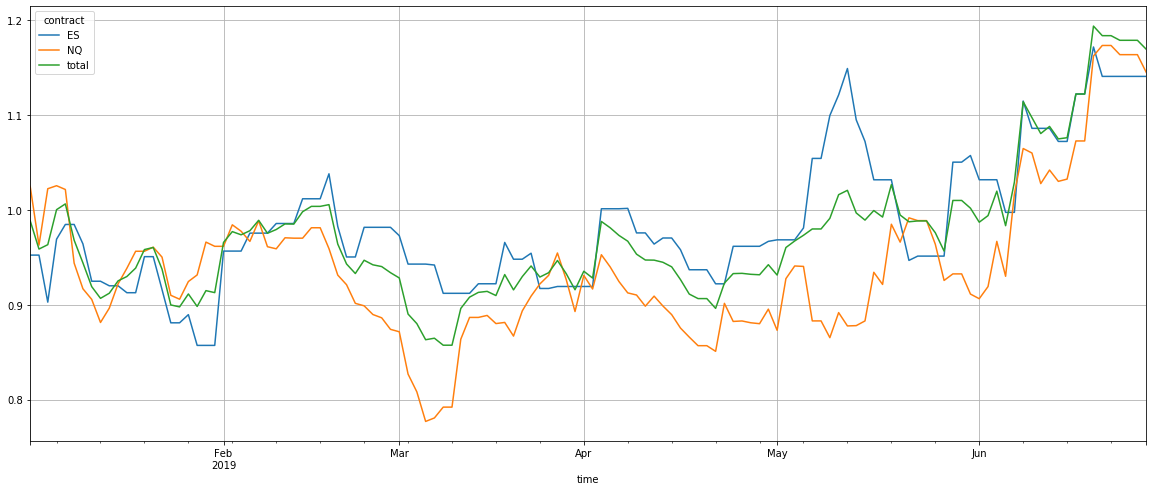

In [19]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,NQ,total
Annual return,0.295971,0.305714,0.360841
Cumulative returns,0.140752,0.145100,0.169407
Annual volatility,0.456754,0.448207,0.333288
Sharpe ratio,0.787925,0.814897,1.087843
Calmar ratio,1.680600,1.261142,2.436842
Stability,0.469297,0.100927,0.366801
Max drawdown,-0.176110,-0.242410,-0.148077
Omega ratio,1.202488,1.159405,1.220754
Sortino ratio,1.440785,1.355975,1.921262
Skew,1.591956,0.708902,1.055689


In [21]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,NQ,total
time,,,
2019-01-31,-14.29,-3.84,-8.73
2019-02-28,14.53,-9.11,2.30
2019-03-31,-6.36,2.15,-1.93
2019-04-30,5.18,0.28,2.88
2019-05-31,9.36,1.78,6.33
2019-06-30,7.89,25.67,16.73


In [22]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       14.0
NQ       15.0
total    17.0
dtype: float64

In [23]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-06-10 02:46:30,ES,SELL,2881.50,2520.8
2019-02-01 20:19:00,ES,SELL,2698.50,2320.8
2019-03-12 07:26:00,NQ,SELL,7212.00,2125.8
2019-05-29 19:09:30,ES,BUY,2782.50,2083.3
2019-06-07 17:05:30,NQ,SELL,7434.25,2060.8
...,...,...,...,...
2019-05-22 13:58:30,ES,SELL,2852.75,-816.7
2019-05-21 02:35:00,ES,BUY,2852.00,-866.7
2019-05-14 05:26:00,ES,BUY,2822.50,-941.7


In [24]:
daily.sort_values('total', ascending=False)

contract,ES,NQ,total
time,,,
2019-06-10,0.117705,0.04712,0.082413
2019-04-03,0.089165,0.03941,0.064287
2019-06-20,0.044165,0.08354,0.063852
2019-02-01,0.116040,0.00000,0.058020
2019-05-29,0.104165,0.00745,0.055808
...,...,...,...
2019-06-06,-0.033335,-0.03809,-0.035713
2019-01-09,0.000000,-0.07601,-0.038005
2019-01-24,-0.038335,-0.04238,-0.040357
